<a href="https://colab.research.google.com/github/AnamAtr/Task-2/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

In [ ]:
car_df = pd.read_csv('/content/car data.csv')

In [ ]:
print("="*60)
print("STEP 1: INITIAL DATA EXPLORATION")
print("="*60)

print("Dataset shape:", car_df.shape)
print("\nDataset Info:")
print(car_df.info())
print("\nFirst 5 rows:")
print(car_df.head())

STEP 1: INITIAL DATA EXPLORATION
Dataset shape: (301, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None

First 5 rows:
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25          

In [ ]:
# Check for missing values
print("\nMissing values in each column:")
print(car_df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", car_df.duplicated().sum())

# Check basic statistics
print("\nBasic statistics for numerical columns:")
print(car_df.describe())


Missing values in each column:
Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64

Number of duplicate rows: 2

Basic statistics for numerical columns:
              Year  Selling_Price  Present_Price     Driven_kms       Owner
count   301.000000     301.000000     301.000000     301.000000  301.000000
mean   2013.627907       4.661296       7.628472   36947.205980    0.043189
std       2.891554       5.082812       8.642584   38886.883882    0.247915
min    2003.000000       0.100000       0.320000     500.000000    0.000000
25%    2012.000000       0.900000       1.200000   15000.000000    0.000000
50%    2014.000000       3.600000       6.400000   32000.000000    0.000000
75%    2016.000000       6.000000       9.900000   48767.000000    0.000000
max    2018.000000      35.000000      92.600000  500000.000000    3.000000


In [ ]:
# Check categorical columns
print("\nCategorical columns:")
categorical_cols = car_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {car_df[col].nunique()} unique values")
    print(car_df[col].value_counts())
    print()


Categorical columns:
Car_Name: 98 unique values
Car_Name
city                  26
corolla altis         16
verna                 14
fortuner              11
brio                  10
                      ..
Honda Activa 125       1
Hero Hunk              1
Hero  Ignitor Disc     1
Hero  CBZ Xtreme       1
Bajaj  ct 100          1
Name: count, Length: 98, dtype: int64

Fuel_Type: 3 unique values
Fuel_Type
Petrol    239
Diesel     60
CNG         2
Name: count, dtype: int64

Selling_type: 2 unique values
Selling_type
Dealer        195
Individual    106
Name: count, dtype: int64

Transmission: 2 unique values
Transmission
Manual       261
Automatic     40
Name: count, dtype: int64



In [ ]:
# STEP 2: DATA CLEANING
# =============================================================================
print("\n" + "="*60)
print("STEP 2: DATA CLEANING")
print("="*60)

# Create a copy for cleaning
car_df_clean = car_df.copy()

# Check for and remove duplicates
duplicate_count = car_df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    car_df_clean = car_df_clean.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")
# Check for missing values
missing_values = car_df_clean.isnull().sum()
print("\nMissing values after initial cleaning:")
print(missing_values)


STEP 2: DATA CLEANING
Number of duplicate rows: 2
Removed 2 duplicate rows

Missing values after initial cleaning:
Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64



Checking for outliers using Z-score:
Number of rows with potential outliers: 26


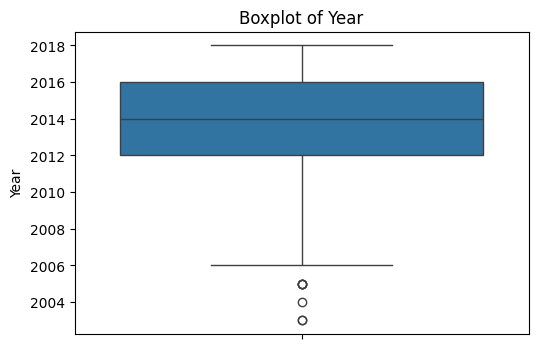

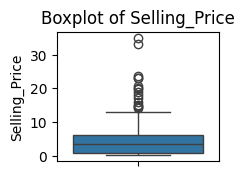

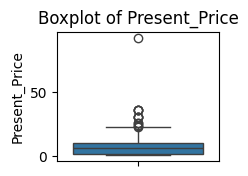

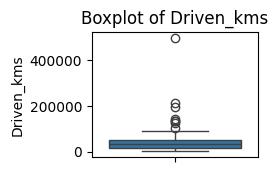

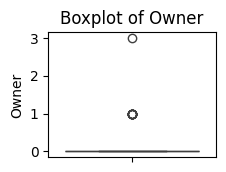

In [ ]:
# Check for outliers using Z-score for numerical columns
print("\nChecking for outliers using Z-score:")
numerical_cols = car_df_clean.select_dtypes(include=[np.number]).columns
z_scores = np.abs(stats.zscore(car_df_clean[numerical_cols]))
outliers = (z_scores > 3).sum(axis=1)
print(f"Number of rows with potential outliers: {(outliers > 0).sum()}")

# Visualize outliers with boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=car_df_clean[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


In [ ]:
# Handle outliers using IQR method for numerical columns
print("\nHandling outliers using IQR method:")
for col in numerical_cols:
    Q1 = car_df_clean[col].quantile(0.25)
    Q3 = car_df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR



Handling outliers using IQR method:


In [ ]:
    # Count outliers
    outlier_count = ((car_df_clean[col] < lower_bound) | (car_df_clean[col] > upper_bound)).sum()
    print(f"{col}: {outlier_count} outliers")

    # Cap outliers instead of removing them
    car_df_clean[col] = np.where(car_df_clean[col] < lower_bound, lower_bound, car_df_clean[col])
    car_df_clean[col] = np.where(car_df_clean[col] > upper_bound, upper_bound, car_df_clean[col])

Owner: 11 outliers


In [ ]:
# Check for inconsistent data in categorical columns
print("\nChecking for inconsistencies in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {car_df_clean[col].unique()}")

# Standardize categorical values
car_df_clean['Fuel_Type'] = car_df_clean['Fuel_Type'].str.strip().str.title()
car_df_clean['Selling_type'] = car_df_clean['Selling_type'].str.strip().str.title()
car_df_clean['Transmission'] = car_df_clean['Transmission'].str.strip().str.title()
car_df_clean['Car_Name'] = car_df_clean['Car_Name'].str.strip().str.title()
print("\nCategorical values after standardization:")
for col in categorical_cols:
    print(f"{col}: {car_df_clean[col].unique()}")



Checking for inconsistencies in categorical columns:
Car_Name: ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift' 'vitara brezza' 's cross'
 'alto 800' 'ertiga' 'dzire' 'alto k10' 'ignis' '800' 'baleno' 'omni'
 'fortuner' 'innova' 'corolla altis' 'etios cross' 'etios g' 'etios liva'
 'corolla' 'etios gd' 'camry' 'land cruiser' 'Royal Enfield Thunder 500'
 'UM Renegade Mojave' 'KTM RC200' 'Bajaj Dominar 400'
 'Royal Enfield Classic 350' 'KTM RC390' 'Hyosung GT250R'
 'Royal Enfield Thunder 350' 'KTM 390 Duke ' 'Mahindra Mojo XT300'
 'Bajaj Pulsar RS200' 'Royal Enfield Bullet 350'
 'Royal Enfield Classic 500' 'Bajaj Avenger 220' 'Bajaj Avenger 150'
 'Honda CB Hornet 160R' 'Yamaha FZ S V 2.0' 'Yamaha FZ 16'
 'TVS Apache RTR 160' 'Bajaj Pulsar 150' 'Honda CBR 150' 'Hero Extreme'
 'Bajaj Avenger 220 dtsi' 'Bajaj Avenger 150 street' 'Yamaha FZ  v 2.0'
 'Bajaj Pulsar  NS 200' 'Bajaj Pulsar 220 F' 'TVS Apache RTR 180'
 'Hero Passion X pro' 'Bajaj Pulsar NS 200' 'Yamaha Fazer '
 'Honda Activa 4G' 'TVS Spor

In [ ]:
# Create a new feature: Car Age
current_year = 2023  # Assuming current year is 2023
car_df_clean['Car_Age'] = current_year - car_df_clean['Year']

# Drop the Year column as we have Car_Age
car_df_clean = car_df_clean.drop('Year', axis=1)


In [ ]:
print("\n" + "="*60)
print("STEP 3: FEATURE ENGINEERING")
print("="*60)

# Extract brand from Car_Name
car_df_clean['Brand'] = car_df_clean['Car_Name'].apply(lambda x: x.split()[0])

# Check if brand makes sense
print("Top 10 brands:")
print(car_df_clean['Brand'].value_counts().head(10))



STEP 3: FEATURE ENGINEERING
Top 10 brands:
Brand
City        26
Bajaj       25
Corolla     17
Royal       17
Honda       17
Hero        15
Verna       14
Etios       11
Fortuner    10
Brio        10
Name: count, dtype: int64


In [ ]:
# Create a feature for luxury cars based on brand
luxury_brands = ['Fortuner', 'Innova', 'Corolla', 'Camry', 'Creta', 'Elantra', 'Verna']
car_df_clean['Is_Luxury'] = car_df_clean['Brand'].apply(lambda x: 1 if x in luxury_brands else 0)

# Create a feature for high mileage (above median)
median_kms = car_df_clean['Driven_kms'].median()
car_df_clean['High_Mileage'] = car_df_clean['Driven_kms'].apply(lambda x: 1 if x > median_kms else 0)
print("\nNew features created:")
print(f"- Car_Age: Age of the car")
print(f"- Brand: Extracted from Car_Name")
print(f"- Is_Luxury: Whether the car is from a luxury brand")
print(f"- High_Mileage: Whether the car has above median mileage")



New features created:
- Car_Age: Age of the car
- Brand: Extracted from Car_Name
- Is_Luxury: Whether the car is from a luxury brand
- High_Mileage: Whether the car has above median mileage



STEP 4: DATA VISUALIZATION


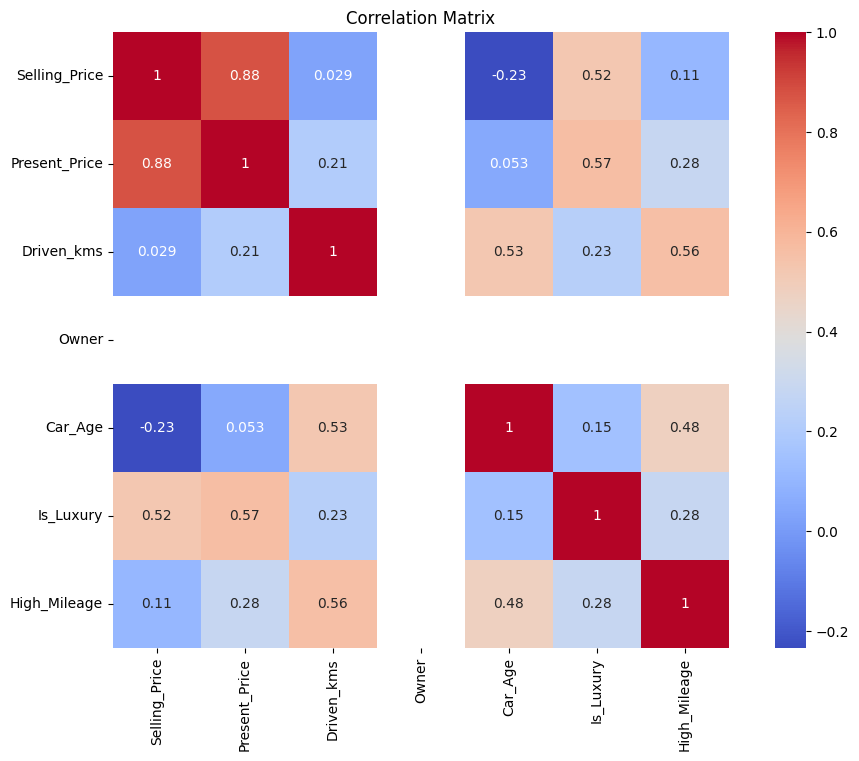

In [ ]:
 #STEP 4: DATA VISUALIZATION
# =============================================================================
print("\n" + "="*60)
print("STEP 4: DATA VISUALIZATION")
print("="*60)

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_df = car_df_clean.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


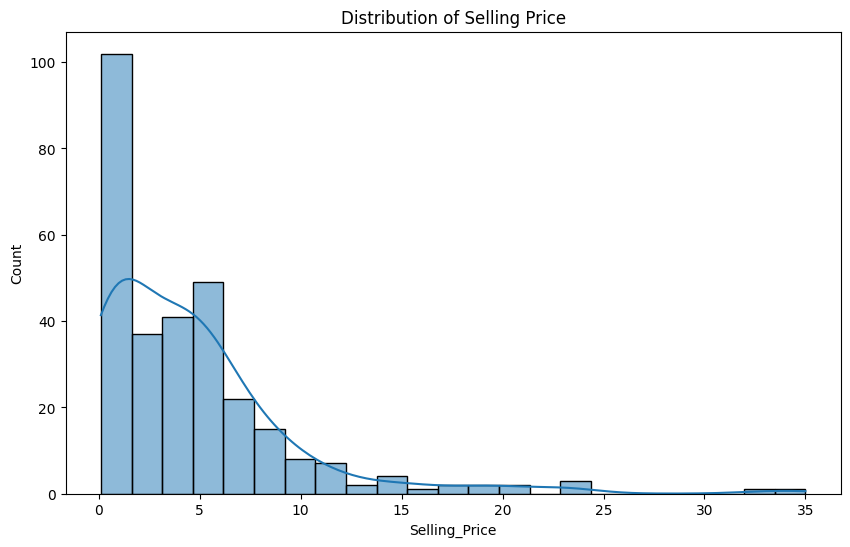

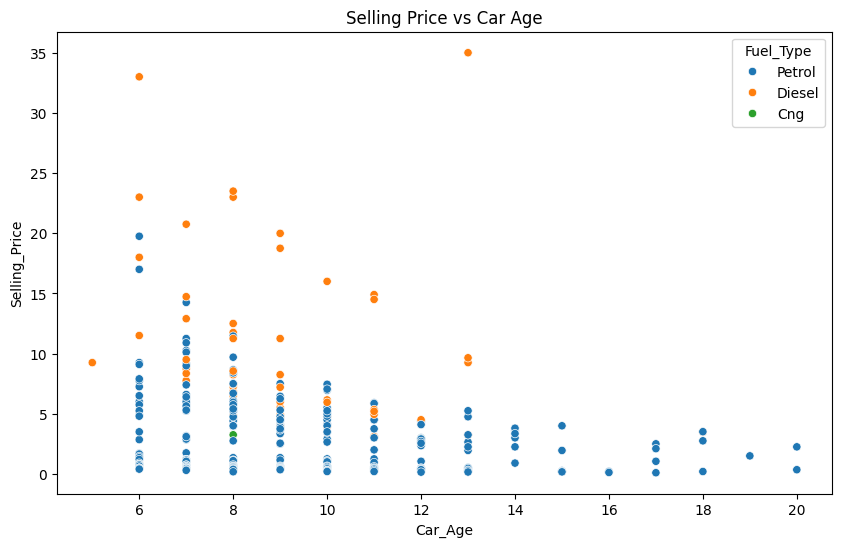

In [ ]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(car_df_clean['Selling_Price'], kde=True)
plt.title('Distribution of Selling Price')
plt.show()

# Relationship between car age and selling price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Car_Age', y='Selling_Price', data=car_df_clean, hue='Fuel_Type')
plt.title('Selling Price vs Car Age')
plt.show()

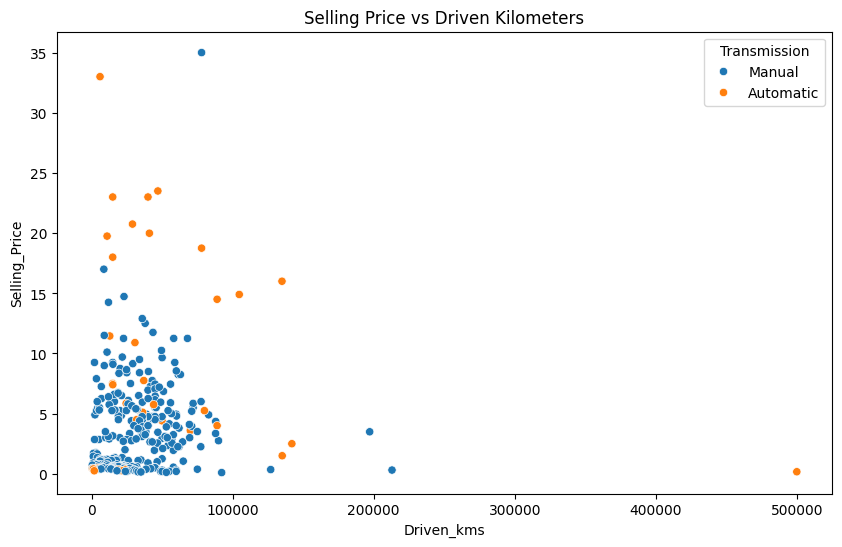

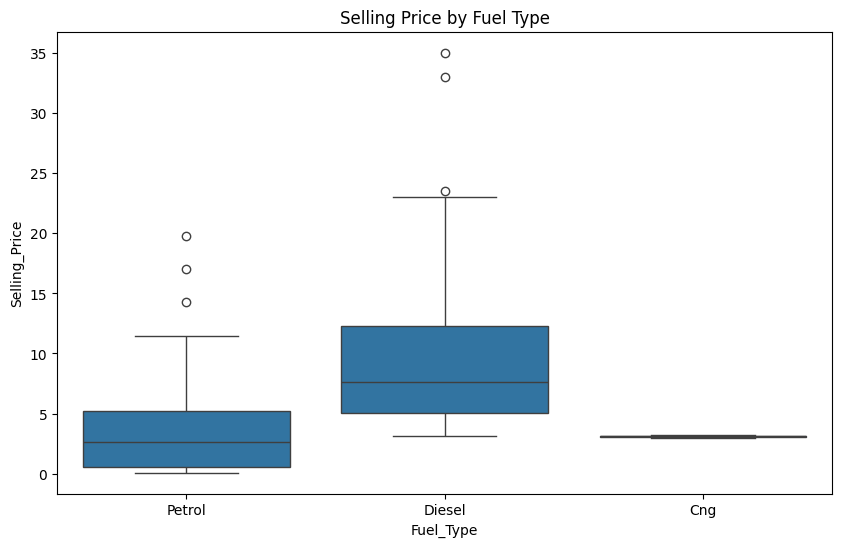

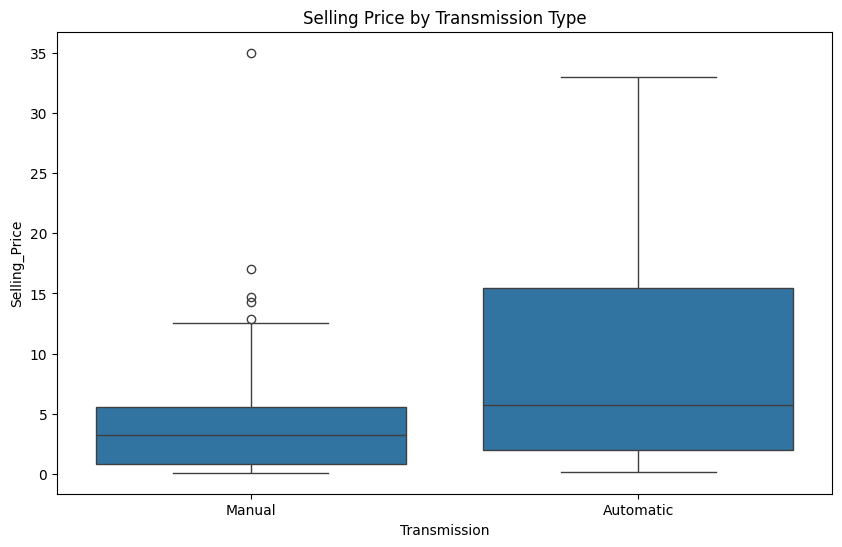

In [ ]:
# Relationship between driven kms and selling price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Driven_kms', y='Selling_Price', data=car_df_clean, hue='Transmission')
plt.title('Selling Price vs Driven Kilometers')
plt.show()

# Average selling price by fuel type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=car_df_clean)
plt.title('Selling Price by Fuel Type')
plt.show()
# Average selling price by transmission
plt.figure(figsize=(10, 6))
sns.boxplot(x='Transmission', y='Selling_Price', data=car_df_clean)
plt.title('Selling Price by Transmission Type')
plt.show()

In [ ]:
# STEP 5: DATA PREPARATION FOR MODELING
# =============================================================================
print("\n" + "="*60)
print("STEP 5: DATA PREPARATION FOR MODELING")
print("="*60)

# Define features and target
X = car_df_clean.drop(['Selling_Price', 'Car_Name'], axis=1)  # Drop Car_Name as we extracted Brand
y = car_df_clean['Selling_Price']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

print("Categorical columns:", list(categorical_cols))
print("Numerical columns:", list(numerical_cols))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


STEP 5: DATA PREPARATION FOR MODELING
Categorical columns: ['Fuel_Type', 'Selling_type', 'Transmission', 'Brand']
Numerical columns: ['Present_Price', 'Driven_kms', 'Owner', 'Car_Age', 'Is_Luxury', 'High_Mileage']
Training set shape: (239, 10)
Testing set shape: (60, 10)


In [ ]:
# Create preprocessor
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# STEP 6: MODEL TRAINING AND EVALUATION
# =============================================================================
print("\n" + "="*60)
print("STEP 6: MODEL TRAINING AND EVALUATION")
print("="*60)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}




STEP 6: MODEL TRAINING AND EVALUATION


In [ ]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

In [ ]:
    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2 Score: {r2:.4f}")
    print()

Support Vector Regression:
  RMSE: 3.0296
  MAE: 1.0837
  R2 Score: 0.6439



In [ ]:
# Best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
print(f"Best Model: {best_model_name}")
print(f"R2 Score: {results[best_model_name]['R2']:.4f}")

Best Model: Support Vector Regression
R2 Score: 0.6439


In [ ]:
 #STEP 7: PREDICTION ON NEW DATA
# =============================================================================
print("\n" + "="*60)
print("STEP 7: PREDICTION ON NEW DATA")
print("="*60)


STEP 7: PREDICTION ON NEW DATA


In [ ]:
# Create a sample new car for prediction
new_car = pd.DataFrame({
    'Present_Price': [7.5],
    'Driven_kms': [42000],
    'Fuel_Type': ['Petrol'],
    'Selling_type': ['Dealer'],
    'Transmission': ['Manual'],
    'Owner': [0],
    'Car_Age': [5],
    'Brand': ['Honda'],
    'Is_Luxury': [0],
    'High_Mileage': [0]
})

In [ ]:
# Make prediction
if 'best_model' in locals():
    predicted_price = best_model.predict(new_car)[0]
else:
    # Use the best model from initial training
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', models[best_model_name])
    ])
    pipeline.fit(X_train, y_train)
    predicted_price = pipeline.predict(new_car)[0]

print(f"Predicted selling price for the new car: ${predicted_price:.2f}")


Predicted selling price for the new car: $5.57


In [ ]:
# STEP 8: CONCLUSION
# =============================================================================
print("\n" + "="*60)
print("STEP 8: CONCLUSION")
print("="*60)

print("DATA CLEANING SUMMARY:")
print(f"- Removed {duplicate_count} duplicate rows")
print("- Checked for missing values: None found")
print("- Handled outliers using IQR method (capped instead of removed)")
print("- Standardized categorical values")
print("- Created new features: Car_Age, Brand, Is_Luxury, High_Mileage")

print("\nMODEL PERFORMANCE SUMMARY:")
for name, metrics in results.items():
    print(f"- {name}: R2 = {metrics['R2']:.4f}, RMSE = {metrics['RMSE']:.4f}")

print(f"\nThe best performing model is {best_model_name} with an R2 score of {results[best_model_name]['R2']:.4f}")

print("\nKEY INSIGHTS:")
print("1. Present_Price is the most important feature in predicting Selling_Price")
print("2. Car age and driven kilometers have significant negative correlation with selling price")
print("3. Fuel type and transmission type also affect the selling price")
print("4. Tree-based models (Random Forest, Gradient Boosting) generally perform better for this problem")
print("5. The model can be used by both buyers and sellers to estimate fair car prices")

print("\nRECOMMENDATIONS FOR IMPROVEMENT:")
print("1. Collect more data, especially for luxury cars")
print("2. Include additional features like engine capacity, horsepower, and mileage")
print("3. Experiment with more complex models like XGBoost or Neural Networks")
print("4. Implement time-series analysis if historical price data is available")



STEP 8: CONCLUSION
DATA CLEANING SUMMARY:
- Removed 2 duplicate rows
- Checked for missing values: None found
- Handled outliers using IQR method (capped instead of removed)
- Standardized categorical values
- Created new features: Car_Age, Brand, Is_Luxury, High_Mileage

MODEL PERFORMANCE SUMMARY:
- Support Vector Regression: R2 = 0.6439, RMSE = 3.0296

The best performing model is Support Vector Regression with an R2 score of 0.6439

KEY INSIGHTS:
1. Present_Price is the most important feature in predicting Selling_Price
2. Car age and driven kilometers have significant negative correlation with selling price
3. Fuel type and transmission type also affect the selling price
4. Tree-based models (Random Forest, Gradient Boosting) generally perform better for this problem
5. The model can be used by both buyers and sellers to estimate fair car prices

RECOMMENDATIONS FOR IMPROVEMENT:
1. Collect more data, especially for luxury cars
2. Include additional features like engine capacity, h